# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [1]:
import glob
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from python_pdb.aligners import align_sequences, align
from python_pdb.comparisons import rmsd
from python_pdb.entities import Structure
from python_pdb.parsers import parse_pdb
from python_pdb.formats.pdb import (ALT_LOC_RANGE, ATOM_NAME_RANGE, ATOM_NUMBER_RANGE, B_FACTOR_RANGE,
                                                     CHAIN_ID_RANGE, CHARGE_RANGE, ELEMENT_RANGE, INSERT_CODE_RANGE,
                                                     OCCUPANCY_RANGE, RESIDUE_NAME_RANGE, SEQ_ID_RANGE, X_POS_RANGE,
                                                     Y_POS_RANGE, Z_POS_RANGE)
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import IMGT_CDR1, IMGT_CDR2, IMGT_CDR3, IMGT_CDR, assign_cdr_number

In [2]:
STCRDAB_PATH = '/project/koohylab/shared/tcr_data/raw_DONOTMODIFY/structure/STCRDab_all_2022-11-10/'
export_path = '../data/apo-holo-mhc-class-I'

# Data selection and processing

## Selecting examples

In the following cell, high quality (<3.50 Å resolution) alpha-beta TCRs that are bound to class I pMHC or are unbound are chosen.

In [3]:
stcrdab_summary = pd.read_csv(os.path.join(STCRDAB_PATH, 'db_summary.dat'), delimiter='\t')
selected_stcrdab = stcrdab_summary.copy()

# Resolution better than 3.50 Å
selected_stcrdab['resolution'] = pd.to_numeric(selected_stcrdab['resolution'], errors='coerce')
selected_stcrdab = selected_stcrdab.query("resolution < 3.50")

# MHC class I bound or unbound
selected_stcrdab = selected_stcrdab.query("(mhc_type == 'MH1') | (mhc_type.isnull() & antigen_type.isnull())", engine='python')
selected_stcrdab['state'] = selected_stcrdab['mhc_type'].map(lambda mhc_type: 'holo' if mhc_type == 'MH1' else 'apo')
selected_stcrdab = selected_stcrdab.drop(columns = ['mhc_type'])

# peptide antigen
selected_stcrdab = selected_stcrdab.query("antigen_type == 'peptide' | state == 'apo'", engine='python')
selected_stcrdab = selected_stcrdab.drop(columns=['antigen_type', 'antigen_het_name'])

# alpha-beta TCRs
selected_stcrdab = selected_stcrdab.query("TCRtype == 'abTCR'")
selected_stcrdab = selected_stcrdab.drop(columns = ['TCRtype',
                                                    'Dchain', 'Gchain',
                                                    'gamma_subgroup', 'delta_subgroup',
                                                    'gamma_organism', 'delta_organism'])

# General clean: drop columns that don't contain anything useful
selected_stcrdab = selected_stcrdab.dropna(axis=1, how='all')


selected_stcrdab

,pdb,Bchain,Achain,model,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,...,antigen_organism,mhc_chain1_organism,mhc_chain2_organism,authors,resolution,method,r_free,r_factor,engineered,state
0,7rk7,E,D,0,C,tyrosinase peptide,A,B,81.339,TRBV10,...,homo sapiens,homo sapiens,homo sapiens,"Singh, N.K., Davancaze, L.M., Arbuiso, A., Wei...",2.54,X-RAY DIFFRACTION,0.255,0.211,True,holo
1,7s8i,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV27,...,NaN,NaN,NaN,"Patskovsky, Y., Nyovanie, S., Patskovska, L., ...",1.66,X-RAY DIFFRACTION,0.216,0.167,True,apo
2,7s8j,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV27,...,NaN,NaN,NaN,"Patskovska, L., Patskovsky, Y., Nyovanie, S., ...",1.92,X-RAY DIFFRACTION,0.213,0.168,True,apo
5,2ak4,E,D,0,C,ebv peptide lpeplpqgqltay,A,B,71.108,TRBV6,...,NaN,homo sapiens,homo sapiens,"Tynan, F.E., Burrows, S.R., Buckle, A.M., Clem...",2.50,X-RAY DIFFRACTION,0.278,0.246,True,holo
6,7nme,E,D,0,C,gln-leu-pro-arg-leu-phe-pro-leu-leu,A,B,36.100,TRBV7,...,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Cole, D.K., Wal...",2.20,X-RAY DIFFRACTION,0.274,0.215,True,holo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,6fr5,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV5,...,NaN,NaN,NaN,"Rizkallah, P.J., Cole, D.K.",1.37,X-RAY DIFFRACTION,0.191,0.168,True,apo
882,5men,E,D,0,C,ile-leu-ala-lys-phe-leu-his-trp-leu,A,B,40.823,TRBV6,...,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Lloyd, A., Crowther, M., Cole...",2.81,X-RAY DIFFRACTION,0.272,0.189,True,holo
883,3vxu,J,I,0,H,10-mer peptide from protein nef,F,G,NaN,TRBV27,...,human immunodeficiency virus 1,homo sapiens,homo sapiens,"Shimizu, A., Fukai, S., Yamagata, A., Iwamoto, A.",2.70,X-RAY DIFFRACTION,0.323,0.272,True,holo
884,6fup,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV24,...,NaN,NaN,NaN,"Rizkallah, P.J., Cole, D.K.",1.72,X-RAY DIFFRACTION,0.215,0.176,True,apo


In [4]:
selected_stcrdab['file_path_imgt'] = selected_stcrdab['pdb'].map(lambda pdb_id: os.path.join(STCRDAB_PATH, 'imgt', pdb_id + '.pdb'))
selected_stcrdab['file_path_raw'] = selected_stcrdab['pdb'].map(lambda pdb_id: os.path.join(STCRDAB_PATH, 'raw', pdb_id + '.pdb'))

## Annotating sequences

Here, the peptide sequence of the alpha chain and beta chain, and if applicable, peptide and MHC complex are collected. These sequences will be used to group similar TCRs.

In [5]:
cdr_1_alpha_seq = []
cdr_2_alpha_seq = []
cdr_3_alpha_seq = []

cdr_1_beta_seq = []
cdr_2_beta_seq = []
cdr_3_beta_seq = []

peptide_seq = []

mhc_chain_1_seq = []
mhc_chain_2_seq = []


for index, stcrdab_entry in selected_stcrdab.iterrows():
    with open(stcrdab_entry['file_path_imgt'], 'r') as fh:
            structure = parse_pdb(fh.read(), silent=True)
    
    # Pre-processing of structure
    structure.dehydrate()
    
    structure_df = structure.to_pandas()

    structure_df['cdr'] = structure_df['residue_seq_id'].map(lambda id_: assign_cdr_number(str(id_)))
    structure_df['res_olc'] = structure_df['residue_name'].map(lambda res_name: THREE_TO_ONE_CODE[res_name] if res_name in THREE_TO_ONE_CODE else None)

    # Alpha CDRs
    cdr_1_alpha_seq.append(''.join(structure_df.query(f"cdr == 1 & chain_id == '{stcrdab_entry['Achain']}'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    cdr_2_alpha_seq.append(''.join(structure_df.query(f"cdr == 2 & chain_id == '{stcrdab_entry['Achain']}'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    cdr_3_alpha_seq.append(''.join(structure_df.query(f"cdr == 3 & chain_id == '{stcrdab_entry['Achain']}'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    # Beta CDRs
    cdr_1_beta_seq.append(''.join(structure_df.query(f"cdr == 1 & chain_id == '{stcrdab_entry['Bchain']}'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    cdr_2_beta_seq.append(''.join(structure_df.query(f"cdr == 2 & chain_id == '{stcrdab_entry['Bchain']}'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    cdr_3_beta_seq.append(''.join(structure_df.query(f"cdr == 3 & chain_id == '{stcrdab_entry['Bchain']}'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    if stcrdab_entry['state'] == 'holo':
        peptide_seq.append(''.join(structure_df.query(f"chain_id == '{stcrdab_entry['antigen_chain']}'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna())
             )
        
        mhc_chain_1_seq.append(''.join(structure_df.query(f"chain_id == '{stcrdab_entry['mhc_chain1']}'")
                                                   .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                                   .dropna())
             )
    
        mhc_chain_2_seq.append(''.join(structure_df.query(f"chain_id == '{stcrdab_entry['mhc_chain2']}'")
                                                   .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                                   .dropna())
         )

    else:
        peptide_seq.append(None)
        mhc_chain_1_seq.append(None)
        mhc_chain_2_seq.append(None)

selected_stcrdab['cdr_1_alpha_seq'] = cdr_1_alpha_seq
selected_stcrdab['cdr_2_alpha_seq'] = cdr_2_alpha_seq
selected_stcrdab['cdr_3_alpha_seq'] = cdr_3_alpha_seq

selected_stcrdab['cdr_1_beta_seq'] = cdr_1_beta_seq
selected_stcrdab['cdr_2_beta_seq'] = cdr_2_beta_seq
selected_stcrdab['cdr_3_beta_seq'] = cdr_3_beta_seq

selected_stcrdab['peptide_seq'] = peptide_seq

selected_stcrdab['mhc_chain_1_seq'] = mhc_chain_1_seq
selected_stcrdab['mhc_chain_2_seq'] = mhc_chain_2_seq

selected_stcrdab

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:53: UserWarning: Residue(HOH, 217) not found in Chain(G).
  warnings.warn(f'{child} not found in {self}.')
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:53: UserWarning: Residue(HOH, 218) not found in Chain(G).
  warnings.warn(f'{child} not found in {self}.')
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:53: UserWarning: Residue(HOH, 219) not found in Chain(G).
  warnings.warn(f'{child} not found in {self}.')
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:53: UserWarning: Residue(HOH, 220) not found in Chain(G).
  warnings.warn(f'{child} not found in {self}.')
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:53: UserWarning: Residue(HOH, 1183) not found in Chain(C).
  warnings.warn(f'{child} not found in {self}.')


,pdb,Bchain,Achain,model,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,...,file_path_raw,cdr_1_alpha_seq,cdr_2_alpha_seq,cdr_3_alpha_seq,cdr_1_beta_seq,cdr_2_beta_seq,cdr_3_beta_seq,peptide_seq,mhc_chain_1_seq,mhc_chain_2_seq
0,7rk7,E,D,0,C,tyrosinase peptide,A,B,81.339,TRBV10,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,NIATNDY,GYKTK,LVALNYGGSQGNLI,ENHRY,SYGVKD,AISPTEEGGLIFPGNTIY,YMDGTMSQV,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPANGKFLNCYVSGFHPSDIEVDKNGRIEKVEHSDLS...
1,7s8i,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV27,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,SVFSS,VVTGGEV,AGYGGGSNYKLT,MNHEY,SMNVEV,ASRLTGRVHGYT,None,None,None
2,7s8j,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV27,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,SVFSS,VVTGGEV,AGYGGGSNYKLT,MNHEY,SMNVEV,ASRLTGRVHGYT,None,None,None
5,2ak4,E,D,0,C,ebv peptide lpeplpqgqltay,A,B,71.108,TRBV6,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,TRDTTYY,RNSFDEQN,ALSGFYNTDKLI,MNHNS,SASEGT,ASPGLAGEYEQY,LPEPLPQGQLTAY,GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTE...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...
6,7nme,E,D,0,C,gln-leu-pro-arg-leu-phe-pro-leu-leu,A,B,36.100,TRBV7,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,DSSSTY,IFSNMDM,AEPSGNTGKLI,SEHNR,FQNEAQ,ASSLHHEQY,QLPRLFPLL,GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,6fr5,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV5,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,DSAIYN,IQSSQRE,AVTNFNKFY,SGHRS,YFSETQ,ASSFDSGNSPLH,None,None,None
882,5men,E,D,0,C,ile-leu-ala-lys-phe-leu-his-trp-leu,A,B,40.823,TRBV6,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,DSVNN,IPSGT,AVDSATSGTYKYI,MNHEY,SVGAGI,ASSYQGTEAF,ILAKFLHWL,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...
883,3vxu,J,I,0,H,10-mer peptide from protein nef,F,G,NaN,TRBV27,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,DRGSQS,IYSNGD,GTYNQGGKLI,MNHEY,SMNVEV,ASSGASHEQY,RFPLTFGWCF,GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...
884,6fup,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV24,...,/project/koohylab/shared/tcr_data/raw_DONOTMOD...,SSVPPY,YTSAATLV,AVSEQDDKII,KGHDR,SFDVKD,ATSDESYGYT,None,None,None


## Finding examples of TCRs with both *apo* and *holo* structures

Using the CDR sequences extracted in the last cell, group TCRs with the same sequence and drop the rest.

In [6]:
apo_holo_dfs = []

for sequences, tcr_group in selected_stcrdab.groupby(['cdr_1_alpha_seq', 'cdr_2_alpha_seq', 'cdr_3_alpha_seq', 'cdr_1_beta_seq', 'cdr_2_beta_seq', 'cdr_3_beta_seq']):
    # Screen out groups that don't have apo and holo forms
    if np.nan not in tcr_group['antigen_chain'].unique().tolist() or len(tcr_group['antigen_chain'].unique()) < 2:
        continue
    tcr_group = tcr_group.copy()
    tcr_group['cdr_sequence_collated'] = '-'.join(sequences)
    
    apo_holo_dfs.append(tcr_group)

apo_holo_tcrs = pd.concat(apo_holo_dfs).reset_index(drop=True)
apo_holo_tcrs

,pdb,Bchain,Achain,model,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,...,cdr_1_alpha_seq,cdr_2_alpha_seq,cdr_3_alpha_seq,cdr_1_beta_seq,cdr_2_beta_seq,cdr_3_beta_seq,peptide_seq,mhc_chain_1_seq,mhc_chain_2_seq,cdr_sequence_collated
0,4qrp,L,K,0,NaN,NaN,NaN,NaN,NaN,TRBV11,...,ATGYPS,ATKADDK,ALSDPVNDMR,SGHAT,FQNNGV,ASSLRGRGDQPQH,None,None,None,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...
1,4qrp,I,J,0,H,ns3-4a protein,F,G,50.258,TRBV11,...,ATGYPS,ATKADDK,ALSDPVNDMR,SGHAT,FQNNGV,ASSLRGRGDQPQH,HSKKKCDEL,GSHSMRYFDTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...
2,4qrp,E,D,0,C,ns3-4a protein,A,B,49.048,TRBV11,...,ATGYPS,ATKADDK,ALSDPVNDMR,SGHAT,FQNNGV,ASSLRGRGDQPQH,HSKKKCDEL,GSHSMRYFDTAMSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREE...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...
3,6rp9,J,I,0,H,cancer/testis antigen 1,F,G,64.203,TRBV7,...,DRGSQS,IYSNGD,ALTRGPGNQFY,SGHVS,FNYEAQ,ASSSPGGVSTEAF,SLLMWITQV,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...,DRGSQS-IYSNGD-ALTRGPGNQFY-SGHVS-FNYEAQ-ASSSPGG...
4,6rp9,L,K,0,NaN,NaN,NaN,NaN,NaN,TRBV7,...,DRGSQS,IYSNGD,ALTRGPGNQFY,SGHVS,FNYEAQ,ASSSPGGVSTEAF,None,None,None,DRGSQS-IYSNGD-ALTRGPGNQFY-SGHVS-FNYEAQ-ASSSPGG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1mwa,D,C,0,Q,dev8,I,M,26.226,TRBV13,...,YSATPY,YYSGDPVV,AVSGFASALT,NNHNN,SYGAGS,ASGGGGTLY,EQYKFYSV,GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYE...,TPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKV...,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
131,2ckb,B,A,0,P,dev8 peptide,H,L,22.691,TRBV13,...,YSATPY,YYSGDPVV,AVSGFASALT,NNHNN,SYGAGS,ASGGGGTLY,EQYKFYSV,GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYE...,TPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKV...,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
132,1tcr,B,A,0,NaN,NaN,NaN,NaN,NaN,TRBV13,...,YSATPY,YYSGDPVV,AVSGFASALT,NNHNN,SYGAGS,ASGGGGTLY,None,None,None,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
133,7n1e,E,D,0,C,spike protein s2,A,B,35.924,TRBV11,...,YSGSPE,HISR,ALSGFNNAGNMLT,SGHAT,FQNNGV,ASSLGGAGGADTQY,RLQSLQTYV,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,TPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKV...,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...


## Exporting the structures of these TCRs

Export the structure of these *apo* and *holo* TCRs for later use...

1. Full TCR and pMHC context

In [7]:
if not os.path.exists(export_path):
    os.mkdir(export_path)

for tcr_cdrs, tcr_group in apo_holo_tcrs.groupby('cdr_sequence_collated'):
    group_path = os.path.join(export_path, tcr_cdrs)
    
    if not os.path.exists(group_path):
        os.mkdir(group_path)
        
    for alpha_chain, beta_chain, antigen_chain, mhc_chain1, mhc_chain2, state, pdb, path in tcr_group[['Achain', 'Bchain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2', 'state', 'pdb', 'file_path_imgt']].itertuples(index=False):
        with open(path, 'r') as fh:
            pdb_contents = fh.read()
            
        full_structure_df = parse_pdb(pdb_contents, silent=True).to_pandas()
    
        
        tcr = full_structure_df.query(f"chain_id == '{alpha_chain}' or chain_id == '{beta_chain}'")
        pmhc = full_structure_df.query(f"chain_id == '{antigen_chain}' or chain_id == '{mhc_chain1}' or chain_id == '{mhc_chain2}'")
        
        tcr_structure = Structure.from_pandas(pd.concat([tcr, pmhc]))
        
        chains = [chain for chain in [alpha_chain, beta_chain, antigen_chain, mhc_chain1, mhc_chain2] if type(chain) is str]
        
        output_name = f"{pdb}_{''.join(chains)}_{state}.pdb"

        with open(os.path.join(group_path, output_name), 'w') as fh:
            fh.write(str(tcr_structure))

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9448, atom_name='N', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=23.272, y_pos=-80.451, z_pos=-32.304, occupancy=0.53, b_factor=54.5, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9449, atom_name='CA', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=24.717, y_pos=-80.628, z_pos=-32.105, occupancy=0.53, b_factor=54.15, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3618, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=14, insert_code=None, x_pos=33.789, y_pos=0.467, z_pos=85.867, occupancy=0.5, b_factor=64.23, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3621, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='A', seq_id=14, insert_code=None, x_pos=33.848, y_pos=-0.861, z_pos=85.051, occupancy=0.5, b_factor=64.72, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn(

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=4999, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=1091, insert_code=None, x_pos=54.85, y_pos=7.392, z_pos=51.199, occupancy=0.5, b_factor=78.12, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5002, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='A', seq_id=1091, insert_code=None, x_pos=54.016, y_pos=6.1, z_pos=50.992, occupancy=0.5, b_factor=76.3, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=1334, atom_name='N', alt_loc='A', res_name='CYS', chain_id='B', seq_id=184, insert_code=None, x_pos=28.455, y_pos=3.985, z_pos=20.385, occupancy=0.5, b_factor=35.76, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=1335, atom_name='CA', alt_loc='A', res_name='CYS', chain_id='B', seq_id=184, insert_code=None, x_pos=29.636, y_pos=4.049, z_pos=21.214, occupancy=0.5, b_factor=37.38, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn(

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5798, atom_name='N', alt_loc='A', res_name='CYS', chain_id='C', seq_id=23, insert_code=None, x_pos=53.562, y_pos=2.482, z_pos=12.184, occupancy=0.5, b_factor=44.83, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5799, atom_name='CA', alt_loc='A', res_name='CYS', chain_id='C', seq_id=23, insert_code=None, x_pos=53.565, y_pos=3.811, z_pos=11.598, occupancy=0.5, b_factor=45.45, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: HetAtomRecord(atom_num=36, atom_name='CB', alt_loc='A', res_name='F2F', chain_id='C', seq_id=5, insert_code=None, x_pos=29.786, y_pos=-17.878, z_pos=-3.955, occupancy=0.5, b_factor=65.83, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: HetAtomRecord(atom_num=37, atom_name='CG', alt_loc='A', res_name='F2F', chain_id='C', seq_id=5, insert_code=None, x_pos=28.628, y_pos=-18.687, z_pos=-3.433, occupancy=0.5, b_factor=65.82, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.wa

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2054, atom_name='CA', alt_loc='A', res_name='ASN', chain_id='A', seq_id=7, insert_code=None, x_pos=68.875, y_pos=40.553, z_pos=71.388, occupancy=0.5, b_factor=36.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2057, atom_name='CB', alt_loc='A', res_name='ASN', chain_id='A', seq_id=7, insert_code=None, x_pos=68.64, y_pos=40.816, z_pos=72.872, occupancy=0.5, b_factor=34.99, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=101, atom_name='N', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=15.735, y_pos=33.262, z_pos=55.276, occupancy=0.5, b_factor=28.58, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=102, atom_name='CA', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=16.278, y_pos=31.896, z_pos=55.247, occupancy=0.5, b_factor=29.9, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{r

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=88, atom_name='N', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=32.715, y_pos=16.099, z_pos=27.914, occupancy=0.5, b_factor=54.25, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=89, atom_name='CA', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=31.334, y_pos=16.531, z_pos=28.072, occupancy=0.5, b_factor=54.04, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{re

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=350, atom_name='N', alt_loc='A', res_name='ARG', chain_id='E', seq_id=43, insert_code=None, x_pos=26.51, y_pos=1.849, z_pos=30.322, occupancy=0.5, b_factor=21.32, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=351, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='E', seq_id=43, insert_code=None, x_pos=25.099, y_pos=2.061, z_pos=30.572, occupancy=0.5, b_factor=19.67, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{r

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=959, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='B', seq_id=123, insert_code=None, x_pos=-120.455, y_pos=-16.302, z_pos=109.133, occupancy=0.55, b_factor=23.3, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=962, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='B', seq_id=123, insert_code=None, x_pos=-121.936, y_pos=-16.426, z_pos=109.542, occupancy=0.55, b_factor=26.46, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warn

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3739, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=6, insert_code=None, x_pos=-43.021, y_pos=-4.416, z_pos=25.234, occupancy=0.5, b_factor=29.92, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3742, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='A', seq_id=6, insert_code=None, x_pos=-44.411, y_pos=-3.841, z_pos=24.954, occupancy=0.5, b_factor=33.66, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=345, atom_name='N', alt_loc='A', res_name='ARG', chain_id='E', seq_id=22, insert_code=None, x_pos=9.223, y_pos=-10.732, z_pos=60.575, occupancy=0.5, b_factor=23.54, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=346, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='E', seq_id=22, insert_code=None, x_pos=10.252, y_pos=-11.485, z_pos=61.277, occupancy=0.5, b_factor=24.38, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7933, atom_name='N', alt_loc='B', res_name='ARG', chain_id='A', seq_id=82, insert_code=None, x_pos=24.065, y_pos=-5.876, z_pos=-15.623, occupancy=0.51, b_factor=32.65, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7934, atom_name='CA', alt_loc='B', res_name='ARG', chain_id='A', seq_id=82, insert_code=None, x_pos=24.425, y_pos=-7.276, z_pos=-15.807, occupancy=0.51, b_factor=36.07, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.w

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11396, atom_name='N', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=7.296, y_pos=23.436, z_pos=62.314, occupancy=0.5, b_factor=38.29, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11397, atom_name='CA', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=8.178, y_pos=22.309, z_pos=62.545, occupancy=0.5, b_factor=37.01, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.w

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7743, atom_name='N', alt_loc='A', res_name='ARG', chain_id='A', seq_id=17, insert_code=None, x_pos=1.775, y_pos=16.847, z_pos=21.04, occupancy=0.5, b_factor=42.36, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7744, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=17, insert_code=None, x_pos=0.752, y_pos=15.791, z_pos=20.871, occupancy=0.5, b_factor=41.88, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=10815, atom_name='N', alt_loc='B', res_name='GLU', chain_id='F', seq_id=58, insert_code=None, x_pos=4.314, y_pos=-32.161, z_pos=-52.06, occupancy=0.55, b_factor=39.99, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=10816, atom_name='CA', alt_loc='B', res_name='GLU', chain_id='F', seq_id=58, insert_code=None, x_pos=5.47, y_pos=-32.318, z_pos=-51.184, occupancy=0.55, b_factor=34.1, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.wa

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5367, atom_name='N', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.705, y_pos=61.105, z_pos=-2.975, occupancy=0.5, b_factor=31.87, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5368, atom_name='CA', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.359, y_pos=62.445, z_pos=-2.491, occupancy=0.5, b_factor=29.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=4462, atom_name='CA', alt_loc='A', res_name='SER', chain_id='J', seq_id=108, insert_code=None, x_pos=88.98, y_pos=21.545, z_pos=-8.465, occupancy=0.5, b_factor=7.01, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=4465, atom_name='CB', alt_loc='A', res_name='SER', chain_id='J', seq_id=108, insert_code=None, x_pos=89.154, y_pos=20.02, z_pos=-8.384, occupancy=0.5, b_factor=9.1, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

2. TCR variable domain only

In [8]:
if not os.path.exists(export_path):
    os.mkdir(export_path)

for tcr_cdrs, tcr_group in apo_holo_tcrs.groupby('cdr_sequence_collated'):
    group_path = os.path.join(export_path, tcr_cdrs, 'variable-only')
    
    if not os.path.exists(group_path):
        os.mkdir(group_path)
        
    for alpha_chain, beta_chain, state, pdb, path in tcr_group[['Achain', 'Bchain', 'state', 'pdb', 'file_path_imgt']].itertuples(index=False):
        with open(path, 'r') as fh:
            pdb_contents = fh.read()
            
        full_structure_df = parse_pdb(pdb_contents).to_pandas()
    
        tcr_variable = full_structure_df.query(f"(chain_id == '{alpha_chain}' or chain_id == '{beta_chain}') and residue_seq_id <= 128")
        
        tcr_structure = Structure.from_pandas(tcr_variable)
        
        chains = [alpha_chain, beta_chain]
        
        output_name = f"{pdb}_{''.join(chains)}_{state}.pdb"

        with open(os.path.join(group_path, output_name), 'w') as fh:
            fh.write(str(tcr_structure))

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9448, atom_name='N', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=23.272, y_pos=-80.451, z_pos=-32.304, occupancy=0.53, b_factor=54.5, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9449, atom_name='CA', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=24.717, y_pos=-80.628, z_pos=-32.105, occupancy=0.53, b_factor=54.15, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9448, atom_name='N', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=23.272, y_pos=-80.451, z_pos=-32.304, occupancy=0.53, b_factor=54.5, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=9449, atom_name='CA', alt_loc='B', res_name='GLU', chain_id='K', seq_id=48, insert_code=None, x_pos=24.717, y_pos=-80.628, z_pos=-32.105, occupancy=0.53, b_factor=54.15, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3618, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=14, insert_code=None, x_pos=33.789, y_pos=0.467, z_pos=85.867, occupancy=0.5, b_factor=64.23, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3621, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='A', seq_id=14, insert_code=None, x_pos=33.848, y_pos=-0.861, z_pos=85.051, occupancy=0.5, b_factor=64.72, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn(

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2681, atom_name='CA', alt_loc='A', res_name='SER', chain_id='D', seq_id=88, insert_code=None, x_pos=32.473, y_pos=-21.413, z_pos=24.255, occupancy=0.5, b_factor=25.84, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2684, atom_name='CB', alt_loc='A', res_name='SER', chain_id='D', seq_id=88, insert_code=None, x_pos=32.89, y_pos=-22.448, z_pos=25.291, occupancy=0.5, b_factor=25.68, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.war

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=1334, atom_name='N', alt_loc='A', res_name='CYS', chain_id='B', seq_id=184, insert_code=None, x_pos=28.455, y_pos=3.985, z_pos=20.385, occupancy=0.5, b_factor=35.76, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=1335, atom_name='CA', alt_loc='A', res_name='CYS', chain_id='B', seq_id=184, insert_code=None, x_pos=29.636, y_pos=4.049, z_pos=21.214, occupancy=0.5, b_factor=37.38, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn(

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5798, atom_name='N', alt_loc='A', res_name='CYS', chain_id='C', seq_id=23, insert_code=None, x_pos=53.562, y_pos=2.482, z_pos=12.184, occupancy=0.5, b_factor=44.83, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5799, atom_name='CA', alt_loc='A', res_name='CYS', chain_id='C', seq_id=23, insert_code=None, x_pos=53.565, y_pos=3.811, z_pos=11.598, occupancy=0.5, b_factor=45.45, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=8381, atom_name='N', alt_loc='A', res_name='HIS', chain_id='A', seq_id=1057, insert_code=None, x_pos=58.027, y_pos=27.236, z_pos=9.895, occupancy=0.5, b_factor=60.22, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=8382, atom_name='CA', alt_loc='A', res_name='HIS', chain_id='A', seq_id=1057, insert_code=None, x_pos=58.413, y_pos=28.291, z_pos=8.963, occupancy=0.5, b_factor=63.64, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.war

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2054, atom_name='CA', alt_loc='A', res_name='ASN', chain_id='A', seq_id=7, insert_code=None, x_pos=68.875, y_pos=40.553, z_pos=71.388, occupancy=0.5, b_factor=36.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2057, atom_name='CB', alt_loc='A', res_name='ASN', chain_id='A', seq_id=7, insert_code=None, x_pos=68.64, y_pos=40.816, z_pos=72.872, occupancy=0.5, b_factor=34.99, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: HetAtomRecord(atom_num=1943, atom_name='O', alt_loc='A', res_name='HOH', chain_id='B', seq_id=264, insert_code=None, x_pos=6.848, y_pos=-23.237, z_pos=37.555, occupancy=0.5, b_factor=2.0, element='O', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3497, atom_name='N', alt_loc='A', res_name='ASN', chain_id='A', seq_id=207, insert_code=None, x_pos=-8.451, y_pos=-13.485, z_pos=40.599, occupancy=0.5, b_factor=41.38, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.wa

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=101, atom_name='N', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=15.735, y_pos=33.262, z_pos=55.276, occupancy=0.5, b_factor=28.58, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=102, atom_name='CA', alt_loc='A', res_name='HIS', chain_id='E', seq_id=5, insert_code=None, x_pos=16.278, y_pos=31.896, z_pos=55.247, occupancy=0.5, b_factor=29.9, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{r

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=1, atom_name='N', alt_loc='A', res_name='ALA', chain_id='C', seq_id=2, insert_code=None, x_pos=48.681, y_pos=-11.013, z_pos=29.6, occupancy=0.5, b_factor=30.86, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2, atom_name='CA', alt_loc='A', res_name='ALA', chain_id='C', seq_id=2, insert_code=None, x_pos=49.343, y_pos=-9.708, z_pos=29.33, occupancy=0.5, b_factor=29.82, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=350, atom_name='N', alt_loc='A', res_name='ARG', chain_id='E', seq_id=43, insert_code=None, x_pos=26.51, y_pos=1.849, z_pos=30.322, occupancy=0.5, b_factor=21.32, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=351, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='E', seq_id=43, insert_code=None, x_pos=25.099, y_pos=2.061, z_pos=30.572, occupancy=0.5, b_factor=19.67, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{r

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=959, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='B', seq_id=123, insert_code=None, x_pos=-120.455, y_pos=-16.302, z_pos=109.133, occupancy=0.55, b_factor=23.3, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=962, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='B', seq_id=123, insert_code=None, x_pos=-121.936, y_pos=-16.426, z_pos=109.542, occupancy=0.55, b_factor=26.46, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warn

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3739, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=6, insert_code=None, x_pos=-43.021, y_pos=-4.416, z_pos=25.234, occupancy=0.5, b_factor=29.92, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=3742, atom_name='CB', alt_loc='A', res_name='ARG', chain_id='A', seq_id=6, insert_code=None, x_pos=-44.411, y_pos=-3.841, z_pos=24.954, occupancy=0.5, b_factor=33.66, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11050, atom_name='N', alt_loc='B', res_name='ARG', chain_id='F', seq_id=82, insert_code=None, x_pos=64.393, y_pos=33.525, z_pos=34.952, occupancy=0.51, b_factor=45.46, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11051, atom_name='CA', alt_loc='B', res_name='ARG', chain_id='F', seq_id=82, insert_code=None, x_pos=64.606, y_pos=33.542, z_pos=33.51, occupancy=0.51, b_factor=48.35, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.wa

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2979, atom_name='N', alt_loc='A', res_name='SER', chain_id='D', seq_id=110, insert_code=None, x_pos=8.367, y_pos=0.613, z_pos=85.701, occupancy=0.5, b_factor=27.06, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=2980, atom_name='CA', alt_loc='A', res_name='SER', chain_id='D', seq_id=110, insert_code=None, x_pos=7.691, y_pos=-0.687, z_pos=85.824, occupancy=0.5, b_factor=27.36, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11396, atom_name='N', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=7.296, y_pos=23.436, z_pos=62.314, occupancy=0.5, b_factor=38.29, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11397, atom_name='CA', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=8.178, y_pos=22.309, z_pos=62.545, occupancy=0.5, b_factor=37.01, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.w

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=345, atom_name='N', alt_loc='A', res_name='ARG', chain_id='E', seq_id=22, insert_code=None, x_pos=9.223, y_pos=-10.732, z_pos=60.575, occupancy=0.5, b_factor=23.54, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=346, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='E', seq_id=22, insert_code=None, x_pos=10.252, y_pos=-11.485, z_pos=61.277, occupancy=0.5, b_factor=24.38, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11396, atom_name='N', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=7.296, y_pos=23.436, z_pos=62.314, occupancy=0.5, b_factor=38.29, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11397, atom_name='CA', alt_loc='A', res_name='GLN', chain_id='F', seq_id=1025, insert_code=None, x_pos=8.178, y_pos=22.309, z_pos=62.545, occupancy=0.5, b_factor=37.01, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.w

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11050, atom_name='N', alt_loc='B', res_name='ARG', chain_id='F', seq_id=82, insert_code=None, x_pos=64.393, y_pos=33.525, z_pos=34.952, occupancy=0.51, b_factor=45.46, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=11051, atom_name='CA', alt_loc='B', res_name='ARG', chain_id='F', seq_id=82, insert_code=None, x_pos=64.606, y_pos=33.542, z_pos=33.51, occupancy=0.51, b_factor=48.35, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.wa

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7743, atom_name='N', alt_loc='A', res_name='ARG', chain_id='A', seq_id=17, insert_code=None, x_pos=1.775, y_pos=16.847, z_pos=21.04, occupancy=0.5, b_factor=42.36, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7744, atom_name='CA', alt_loc='A', res_name='ARG', chain_id='A', seq_id=17, insert_code=None, x_pos=0.752, y_pos=15.791, z_pos=20.871, occupancy=0.5, b_factor=41.88, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7933, atom_name='N', alt_loc='B', res_name='ARG', chain_id='A', seq_id=82, insert_code=None, x_pos=24.065, y_pos=-5.876, z_pos=-15.623, occupancy=0.51, b_factor=32.65, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=7934, atom_name='CA', alt_loc='B', res_name='ARG', chain_id='A', seq_id=82, insert_code=None, x_pos=24.425, y_pos=-7.276, z_pos=-15.807, occupancy=0.51, b_factor=36.07, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.w

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5367, atom_name='N', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.705, y_pos=61.105, z_pos=-2.975, occupancy=0.5, b_factor=31.87, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5368, atom_name='CA', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.359, y_pos=62.445, z_pos=-2.491, occupancy=0.5, b_factor=29.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5367, atom_name='N', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.705, y_pos=61.105, z_pos=-2.975, occupancy=0.5, b_factor=31.87, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5368, atom_name='CA', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.359, y_pos=62.445, z_pos=-2.491, occupancy=0.5, b_factor=29.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5367, atom_name='N', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.705, y_pos=61.105, z_pos=-2.975, occupancy=0.5, b_factor=31.87, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5368, atom_name='CA', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.359, y_pos=62.445, z_pos=-2.491, occupancy=0.5, b_factor=29.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5367, atom_name='N', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.705, y_pos=61.105, z_pos=-2.975, occupancy=0.5, b_factor=31.87, element='N', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=5368, atom_name='CA', alt_loc='A', res_name='GLU', chain_id='C', seq_id=3, insert_code=None, x_pos=22.359, y_pos=62.445, z_pos=-2.491, occupancy=0.5, b_factor=29.11, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=884, atom_name='CA', alt_loc='A', res_name='SER', chain_id='E', seq_id=108, insert_code=None, x_pos=49.037, y_pos=14.852, z_pos=75.339, occupancy=0.5, b_factor=13.74, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=887, atom_name='CB', alt_loc='A', res_name='SER', chain_id='E', seq_id=108, insert_code=None, x_pos=49.226, y_pos=13.332, z_pos=75.433, occupancy=0.5, b_factor=14.92, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn

/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=20, atom_name='CA', alt_loc='B', res_name='GLU', chain_id='B', seq_id=4, insert_code=None, x_pos=69.792, y_pos=-8.385, z_pos=5.268, occupancy=0.54, b_factor=45.58, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{record}: ATOM contains alternate location. '
/home/b/bmcmaste/.local/lib/python3.11/site-packages/python_pdb/entities.py:509: StructureConstructionWarning: AtomRecord(atom_num=23, atom_name='CB', alt_loc='B', res_name='GLU', chain_id='B', seq_id=4, insert_code=None, x_pos=68.318, y_pos=-7.962, z_pos=5.439, occupancy=0.54, b_factor=49.24, element='C', charge=None): ATOM contains alternate location. The `split_states` method can be used to separate these possible conformations into separate models.
  warnings.warn((f'{r

## Alignment

The next step is to align the same TCR (and pMHC if present) structures to the TCR framework regions (TCR variable domain not including the CDR loops) so that the comparisons can be computed using RMSD.

In [11]:
def get_fw_region_from_df(df):
    '''Get Fw region of TCR.'''
    df = df.copy()
    df = df.query('residue_seq_id < 128')
    cdr = df['residue_seq_id'].map(lambda num: num in IMGT_CDR)
    df = df[cdr == False]
    
    return df
    

def get_chain_annotations(file_path):
    chains = file_path.split('_')[1]
    
    return {annotation: chain 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}


def get_sequence_from_df(df):
    df = df.copy()
    
    df = df[['residue_name', 'residue_seq_id', 'residue_insert_code']]
    df = df.drop_duplicates()
    
    df['valid_res'] = df['residue_name'].map(lambda tlc: tlc in THREE_TO_ONE_CODE)
    df = df[df['valid_res']]
    
    seq = df['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
    
    return ''.join(seq)


for group in os.listdir(export_path):
    output_path = os.path.join(export_path, group, 'aligned')
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    pdb_files = sorted([file_ for file_ in os.listdir(os.path.join(export_path, group)) if file_.endswith('.pdb')])
    
    # Align on first file
    reference_file = pdb_files[0]
    reference_chains = get_chain_annotations(reference_file)

    with open(os.path.join(export_path, group, reference_file), 'r') as fh:
        reference_structure = parse_pdb(fh.read(), silent=True)
    
    reference_structure_df = reference_structure.to_pandas()
    reference_structure_df = reference_structure_df.query("record_type == 'ATOM'")
    
    ref_alpha_chain_df = reference_structure_df.query(f"chain_id == '{reference_chains['alpha_chain']}'")
    ref_beta_chain_df = reference_structure_df.query(f"chain_id == '{reference_chains['beta_chain']}'")
    
    ref_alpha_fw_df = get_fw_region_from_df(ref_alpha_chain_df)
    ref_beta_fw_df = get_fw_region_from_df(ref_beta_chain_df)
    
    ref_alpha_fw_ca_df = ref_alpha_fw_df.query("atom_name == 'CA'")
    ref_beta_fw_ca_df = ref_beta_fw_df.query("atom_name == 'CA'")
    
    ref_alpha_chain_seq = get_sequence_from_df(ref_alpha_fw_df)
    ref_beta_chain_seq = get_sequence_from_df(ref_beta_fw_df)
    
    for path in pdb_files:
        chains = get_chain_annotations(path)
        with open(os.path.join(export_path, group, path), 'r') as fh:
            structure = parse_pdb(fh.read(), silent=True)
        
        structure_df = structure.to_pandas()
        structure_df = structure_df.query("record_type == 'ATOM'")
        
        alpha_chain = structure_df.query(f"chain_id == '{chains['alpha_chain']}'")
        beta_chain = structure_df.query(f"chain_id == '{chains['beta_chain']}'")
        
        alpha_fw = get_fw_region_from_df(alpha_chain)
        beta_fw = get_fw_region_from_df(beta_chain)
        
        alpha_fw_ca = alpha_fw.query("atom_name == 'CA'")
        beta_fw_ca = beta_fw.query("atom_name == 'CA'")
        
        alpha_chain_seq = get_sequence_from_df(alpha_fw)
        beta_chain_seq = get_sequence_from_df(beta_fw)
        
        alpha_alignment, _ = align_sequences(alpha_chain_seq, ref_alpha_chain_seq)
        beta_alignment, _ = align_sequences(beta_chain_seq, ref_beta_chain_seq)

        mobile_coords = []
        target_coords = []
        
        iter_mobile = alpha_fw_ca.itertuples()
        iter_target = ref_alpha_fw_ca_df.itertuples()
        
        for res_id_1, res_id_2 in alpha_alignment:
            next_res_1 = next(iter_mobile) if res_id_1 != '-' else None
            next_res_2 = next(iter_target) if res_id_2 != '-' else None

            if next_res_1 and next_res_2:
                mobile_coords.append((next_res_1.pos_x, next_res_1.pos_y, next_res_1.pos_z))
                target_coords.append((next_res_2.pos_x, next_res_2.pos_y, next_res_2.pos_z))
        
        iter_mobile = beta_fw_ca.itertuples()
        iter_target = ref_beta_fw_ca_df.itertuples()
        
        for res_id_1, res_id_2 in beta_alignment:
            next_res_1 = next(iter_mobile) if res_id_1 != '-' else None
            next_res_2 = next(iter_target) if res_id_2 != '-' else None

            if next_res_1 and next_res_2:
                mobile_coords.append((next_res_1.pos_x, next_res_1.pos_y, next_res_1.pos_z))
                target_coords.append((next_res_2.pos_x, next_res_2.pos_y, next_res_2.pos_z))

        mobile_coords = np.array(mobile_coords)
        target_coords = np.array(target_coords)
        
        aligned_structure = align(mobile_coords, target_coords, structure)
        
        with open(os.path.join(output_path, path), 'w') as fh:
            fh.write(str(aligned_structure))


## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons.

In [12]:
def get_chain_assignments(file_path):
    chains = file_path.split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(export_path):
    pdb_files = [file for file in os.listdir(os.path.join(export_path, group, 'aligned')) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        chains1 = get_chain_assignments(path1)
        chains2 = get_chain_assignments(path2)
        
        with open(os.path.join(export_path, group, 'aligned', path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(export_path, group, 'aligned', path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: chains1[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: chains2[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        structure1_df['backbone'] = structure1_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        structure2_df['backbone'] = structure2_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        
        struct_1_cdr_1_alpha_backbone = structure1_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone")
        struct_1_cdr_2_alpha_backbone = structure1_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone")
        struct_1_cdr_3_alpha_backbone = structure1_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone")
        
        struct_1_cdr_1_beta_backbone = structure1_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone")
        struct_1_cdr_2_beta_backbone = structure1_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone")
        struct_1_cdr_3_beta_backbone = structure1_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone")
        
        struct_2_cdr_1_alpha_backbone = structure2_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone")
        struct_2_cdr_2_alpha_backbone = structure2_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone")
        struct_2_cdr_3_alpha_backbone = structure2_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone")
        
        struct_2_cdr_1_beta_backbone = structure2_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone")
        struct_2_cdr_2_beta_backbone = structure2_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone")
        struct_2_cdr_3_beta_backbone = structure2_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone")
        
        for _ in range(6):
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
        
        for _ in range(3):
            chain_types.append('alpha')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_alpha_backbone), get_coords(struct_2_cdr_1_alpha_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_alpha_backbone), get_coords(struct_2_cdr_2_alpha_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_alpha_backbone), get_coords(struct_2_cdr_3_alpha_backbone)))
        
        for _ in range(3):
            chain_types.append('beta')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_beta_backbone), get_coords(struct_2_cdr_1_beta_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_beta_backbone), get_coords(struct_2_cdr_2_beta_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_beta_backbone), get_coords(struct_2_cdr_3_beta_backbone)))

4qrp_DECAB_holo.pdb 4qrp_JIHFG_holo.pdb
4qrp_DECAB_holo.pdb 4qrp_KL_apo.pdb
4qrp_JIHFG_holo.pdb 4qrp_KL_apo.pdb
7n1c_DE_apo.pdb 7n1e_DECAB_holo.pdb
6avf_ABPHM_holo.pdb 6at6_AB_apo.pdb
3skn_GH_apo.pdb 3sjv_DECAB_holo.pdb
3skn_GH_apo.pdb 3sjv_NOMKL_holo.pdb
3skn_GH_apo.pdb 3sjv_IJHFG_holo.pdb
3skn_GH_apo.pdb 3skn_EF_apo.pdb
3skn_GH_apo.pdb 3skn_CD_apo.pdb
3skn_GH_apo.pdb 3sjv_STRPQ_holo.pdb
3skn_GH_apo.pdb 3skn_AB_apo.pdb
3sjv_DECAB_holo.pdb 3sjv_NOMKL_holo.pdb
3sjv_DECAB_holo.pdb 3sjv_IJHFG_holo.pdb
3sjv_DECAB_holo.pdb 3skn_EF_apo.pdb
3sjv_DECAB_holo.pdb 3skn_CD_apo.pdb
3sjv_DECAB_holo.pdb 3sjv_STRPQ_holo.pdb
3sjv_DECAB_holo.pdb 3skn_AB_apo.pdb
3sjv_NOMKL_holo.pdb 3sjv_IJHFG_holo.pdb
3sjv_NOMKL_holo.pdb 3skn_EF_apo.pdb
3sjv_NOMKL_holo.pdb 3skn_CD_apo.pdb
3sjv_NOMKL_holo.pdb 3sjv_STRPQ_holo.pdb
3sjv_NOMKL_holo.pdb 3skn_AB_apo.pdb
3sjv_IJHFG_holo.pdb 3skn_EF_apo.pdb
3sjv_IJHFG_holo.pdb 3skn_CD_apo.pdb
3sjv_IJHFG_holo.pdb 3sjv_STRPQ_holo.pdb
3sjv_IJHFG_holo.pdb 3skn_AB_apo.pdb
3skn_EF_apo.

4mxq_CDBA_holo.pdb 3tf7_iI_apo.pdb
4n5e_CDBA_holo.pdb 4ms8_CDBA_holo.pdb
4n5e_CDBA_holo.pdb 3tpu_MNRQ_holo.pdb
4n5e_CDBA_holo.pdb 4mvb_CDBA_holo.pdb
4n5e_CDBA_holo.pdb 3tf7_kK_apo.pdb
4n5e_CDBA_holo.pdb 4n0c_GHFE_holo.pdb
4n5e_CDBA_holo.pdb 3tf7_cCBA_holo.pdb
4n5e_CDBA_holo.pdb 3tjh_CDBA_holo.pdb
4n5e_CDBA_holo.pdb 3tf7_iI_apo.pdb
4ms8_CDBA_holo.pdb 3tpu_MNRQ_holo.pdb
4ms8_CDBA_holo.pdb 4mvb_CDBA_holo.pdb
4ms8_CDBA_holo.pdb 3tf7_kK_apo.pdb
4ms8_CDBA_holo.pdb 4n0c_GHFE_holo.pdb
4ms8_CDBA_holo.pdb 3tf7_cCBA_holo.pdb
4ms8_CDBA_holo.pdb 3tjh_CDBA_holo.pdb
4ms8_CDBA_holo.pdb 3tf7_iI_apo.pdb
3tpu_MNRQ_holo.pdb 4mvb_CDBA_holo.pdb
3tpu_MNRQ_holo.pdb 3tf7_kK_apo.pdb
3tpu_MNRQ_holo.pdb 4n0c_GHFE_holo.pdb
3tpu_MNRQ_holo.pdb 3tf7_cCBA_holo.pdb
3tpu_MNRQ_holo.pdb 3tjh_CDBA_holo.pdb
3tpu_MNRQ_holo.pdb 3tf7_iI_apo.pdb
4mvb_CDBA_holo.pdb 3tf7_kK_apo.pdb
4mvb_CDBA_holo.pdb 4n0c_GHFE_holo.pdb
4mvb_CDBA_holo.pdb 3tf7_cCBA_holo.pdb
4mvb_CDBA_holo.pdb 3tjh_CDBA_holo.pdb
4mvb_CDBA_holo.pdb 3tf7_iI_apo.pdb
3

3utt_DECAB_holo.pdb 3utp_DE_apo.pdb
3utt_DECAB_holo.pdb 5c09_DECAB_holo.pdb
3utt_DECAB_holo.pdb 5c0c_IJCAB_holo.pdb
3utt_DECAB_holo.pdb 5c07_DECAB_holo.pdb
3utt_DECAB_holo.pdb 5c07_IJHFG_holo.pdb
3utp_DE_apo.pdb 5c09_DECAB_holo.pdb
3utp_DE_apo.pdb 5c0c_IJCAB_holo.pdb
3utp_DE_apo.pdb 5c07_DECAB_holo.pdb
3utp_DE_apo.pdb 5c07_IJHFG_holo.pdb
5c09_DECAB_holo.pdb 5c0c_IJCAB_holo.pdb
5c09_DECAB_holo.pdb 5c07_DECAB_holo.pdb
5c09_DECAB_holo.pdb 5c07_IJHFG_holo.pdb
5c0c_IJCAB_holo.pdb 5c07_DECAB_holo.pdb
5c0c_IJCAB_holo.pdb 5c07_IJHFG_holo.pdb
5c07_DECAB_holo.pdb 5c07_IJHFG_holo.pdb
6rp9_KL_apo.pdb 6rp9_DECAB_holo.pdb
6rp9_KL_apo.pdb 6rp9_IJHFG_holo.pdb
6rp9_DECAB_holo.pdb 6rp9_IJHFG_holo.pdb
3vxq_DE_apo.pdb 3vxs_DECAB_holo.pdb
3vxq_DE_apo.pdb 3vxq_AB_apo.pdb
3vxq_DE_apo.pdb 3vxr_DECAB_holo.pdb
3vxs_DECAB_holo.pdb 3vxq_AB_apo.pdb
3vxs_DECAB_holo.pdb 3vxr_DECAB_holo.pdb
3vxq_AB_apo.pdb 3vxr_DECAB_holo.pdb
3kpr_DECAB_holo.pdb 3kpr_IJHFG_holo.pdb
3kpr_DECAB_holo.pdb 1mi5_DECAB_holo.pdb
3kpr_DECAB_h

In [13]:
results = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results

,group,struct1,struct2,chain_type,cdr,rmsd
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR1,0.345931
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR2,0.969482
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR3,0.206307
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR1,0.330461
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR2,0.350374
...,...,...,...,...,...,...
3343,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR2,0.859473
3344,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR3,0.863497
3345,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR1,0.583921
3346,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR2,0.318365


In [14]:
results['struct1_form'] = results['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results['struct2_form'] = results['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])
results['combined_structures'] = results.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)
results = results.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])
results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR1,0.345931,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR2,0.969482,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR3,0.206307,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR1,0.330461,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR2,0.350374,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb
...,...,...,...,...,...,...,...,...,...
3343,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR2,0.859473,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb
3344,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR3,0.863497,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb
3345,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR1,0.583921,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb
3346,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR2,0.318365,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb


In [40]:
movement_order = pd.CategoricalDtype(categories=['little movement', 'some movement', 'movement', 'large movement', 'significant movement'], ordered=True)

def categorize_movement(rmsd: float) -> str:
    if rmsd < 0.5:
        return 'little movement'
    
    if 0.5 <= rmsd < 1.0:
        return 'some movement'
    
    if 1.0 <= rmsd < 2.0:
        return 'movement'
    
    if 2.0 <= rmsd < 4.0:
        return 'large movement'
    
    if 4.0 <= rmsd:
        return 'significant movement'

results['movement'] = results['rmsd'].map(categorize_movement).astype(movement_order)
results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,comparison,movement
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR1,0.345931,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb,holo-holo,little movement
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR2,0.969482,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb,holo-holo,some movement
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,alpha,CDR3,0.206307,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb,holo-holo,little movement
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR1,0.330461,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb,holo-holo,little movement
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_JIHFG_holo.pdb,beta,CDR2,0.350374,holo,holo,4qrp_DECAB_holo.pdb-4qrp_JIHFG_holo.pdb,holo-holo,little movement
...,...,...,...,...,...,...,...,...,...,...,...
3343,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR2,0.859473,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3344,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR3,0.863497,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3345,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR1,0.583921,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3346,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR2,0.318365,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,little movement


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

In [63]:
apo_holo = results.query('struct1_form != struct2_form').copy()
apo_holo

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,comparison,movement
6,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_KL_apo.pdb,alpha,CDR1,1.278938,holo,apo,4qrp_DECAB_holo.pdb-4qrp_KL_apo.pdb,apo-holo,movement
7,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_KL_apo.pdb,alpha,CDR2,0.738090,holo,apo,4qrp_DECAB_holo.pdb-4qrp_KL_apo.pdb,apo-holo,some movement
8,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_KL_apo.pdb,alpha,CDR3,2.748760,holo,apo,4qrp_DECAB_holo.pdb-4qrp_KL_apo.pdb,apo-holo,large movement
9,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_KL_apo.pdb,beta,CDR1,0.356269,holo,apo,4qrp_DECAB_holo.pdb-4qrp_KL_apo.pdb,apo-holo,little movement
10,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,4qrp_DECAB_holo.pdb,4qrp_KL_apo.pdb,beta,CDR2,0.900608,holo,apo,4qrp_DECAB_holo.pdb-4qrp_KL_apo.pdb,apo-holo,some movement
...,...,...,...,...,...,...,...,...,...,...,...
3343,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR2,0.859473,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3344,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR3,0.863497,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3345,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR1,0.583921,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement
3346,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR2,0.318365,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,little movement


In [75]:
apo_holo['struct1_pdb_id'] = apo_holo['struct1'].map(lambda path: path.split('_')[0])
apo_holo['struct2_pdb_id'] = apo_holo['struct2'].map(lambda path: path.split('_')[0])

holo_pdb_ids = list(set(apo_holo.query("struct1_form == 'holo'")['struct1_pdb_id'].unique().tolist() + apo_holo.query("struct2_form == 'holo'")['struct2_pdb_id'].unique().tolist()))

apo_holo = apo_holo.query("(struct1_form == 'apo' and struct1_pdb_id not in @holo_pdb_ids) or (struct2_form == 'apo' and struct2_pdb_id not in @holo_pdb_ids)")
apo_holo

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,comparison,movement,struct1_pdb_id,struct2_pdb_id
18,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECAB_holo.pdb,alpha,CDR1,2.361179,apo,holo,7n1c_DE_apo.pdb-7n1e_DECAB_holo.pdb,apo-holo,large movement,7n1c,7n1e
19,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECAB_holo.pdb,alpha,CDR2,2.587196,apo,holo,7n1c_DE_apo.pdb-7n1e_DECAB_holo.pdb,apo-holo,large movement,7n1c,7n1e
20,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECAB_holo.pdb,alpha,CDR3,1.956647,apo,holo,7n1c_DE_apo.pdb-7n1e_DECAB_holo.pdb,apo-holo,movement,7n1c,7n1e
21,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECAB_holo.pdb,beta,CDR1,0.753217,apo,holo,7n1c_DE_apo.pdb-7n1e_DECAB_holo.pdb,apo-holo,some movement,7n1c,7n1e
22,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECAB_holo.pdb,beta,CDR2,0.887135,apo,holo,7n1c_DE_apo.pdb-7n1e_DECAB_holo.pdb,apo-holo,some movement,7n1c,7n1e
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR2,0.859473,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement,7r80,7r7z
3344,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,alpha,CDR3,0.863497,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement,7r80,7r7z
3345,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR1,0.583921,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,some movement,7r80,7r7z
3346,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABECD_holo.pdb,7r7z_AB_apo.pdb,beta,CDR2,0.318365,holo,apo,7r7z_AB_apo.pdb-7r80_ABECD_holo.pdb,apo-holo,little movement,7r80,7r7z


count      mean       std       min       25%       50%   
cdr  chain_type                                                            
CDR1 alpha       137.0  1.178683  0.628255  0.311974  0.748343  0.944574  \
     beta        137.0  0.917690  0.442272  0.203754  0.582196  0.856078   
CDR2 alpha       137.0  1.328229  0.797814  0.407189  0.785446  1.093009   
     beta        137.0  0.927744  0.677399  0.290126  0.497749  0.795731   
CDR3 alpha       137.0  1.748742  1.007858  0.530306  0.978796  1.316265   
     beta        137.0  1.409014  0.721704  0.383694  0.900288  1.204471   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       1.562497  3.170457  
     beta        1.131744  2.297656  
CDR2 alpha       1.605437  4.109209  
     beta        1.120845  3.936314  
CDR3 alpha       2.606772  4.561604  
     beta        1.703700  3.415569

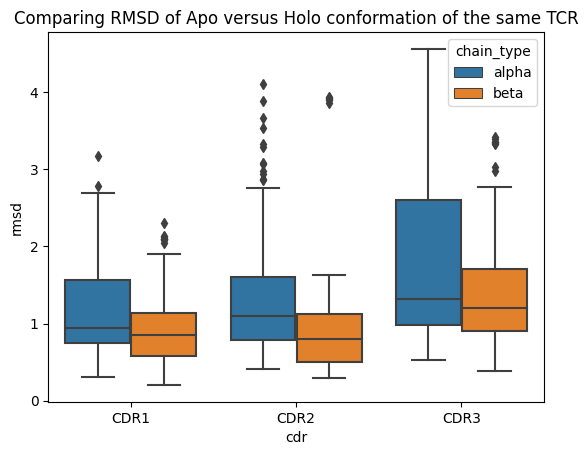

In [76]:
sns.boxplot(data=apo_holo, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

apo_holo.groupby(['cdr', 'chain_type'])['rmsd'].describe()

The figure above shows there appears to be an increase in the movement of CDR3 compared to CDR1 and CDR2 and that the alpha chain has more movement than the beta chain of the TCR.

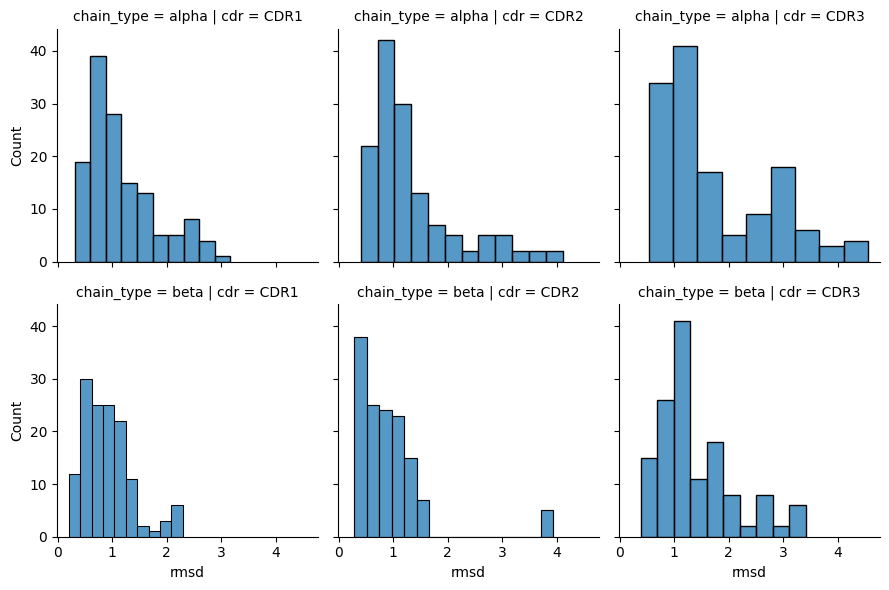

In [77]:
g = sns.FacetGrid(apo_holo, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

The RMSD distributions are somewhat left skewed and don't look particularily normal.

<Axes: ylabel='count'>

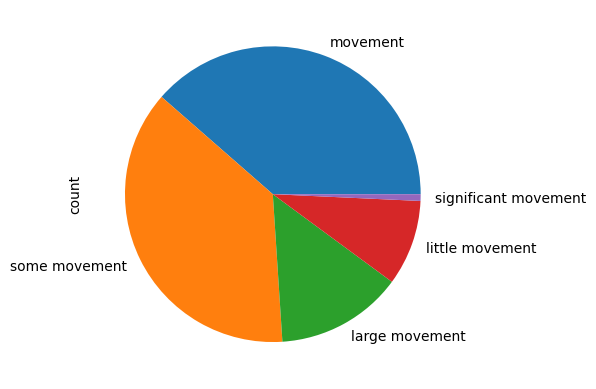

In [78]:
apo_holo['movement'].value_counts().plot.pie()

## Comparison of *apo*-*apo* and *holo*-*holo* to *apo*-*holo* (or vice versa) structures

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *apo*-*apo* and *holo*-*holo* differences as controls.

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


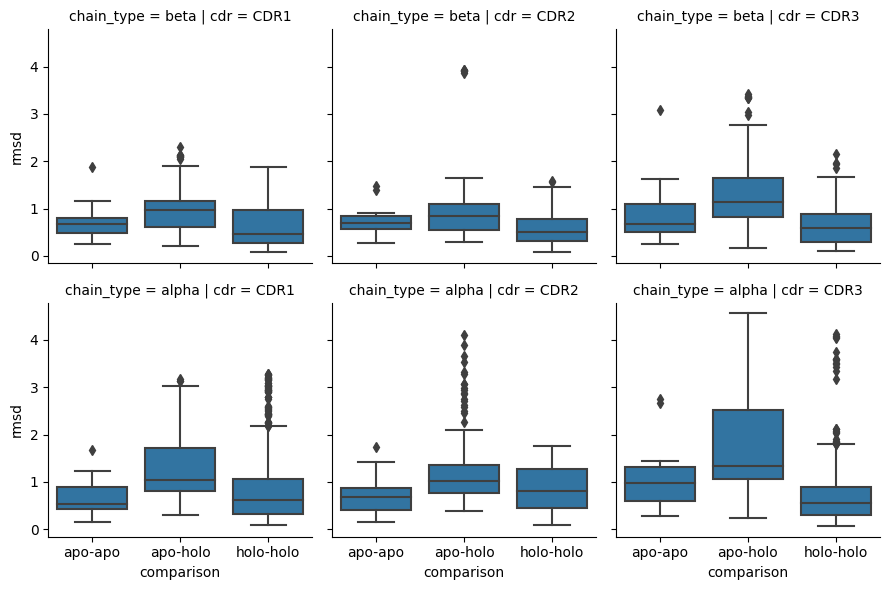

In [82]:
results['comparison'] = results['struct1_form'] + '-' + results['struct2_form']
results['comparison'] = results['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

g = sns.FacetGrid(results.sort_values('comparison'), col='cdr', row='chain_type')
g.map(sns.boxplot, 'comparison', 'rmsd')

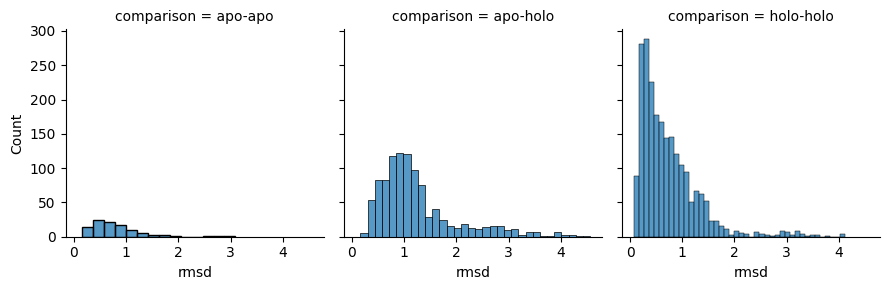

In [19]:
g = sns.FacetGrid(results.sort_values('comparison'), col='comparison')
g.map(sns.histplot, 'rmsd')

In [20]:
sample_apo_apo = results.query("comparison == 'apo-apo'")['rmsd'].to_numpy()
sample_apo_holo = results.query("comparison == 'apo-holo'")['rmsd'].to_numpy()
sample_holo_holo = results.query("comparison == 'holo-holo'")['rmsd'].to_numpy()

print(scipy.stats.kruskal(sample_apo_apo, sample_apo_holo, sample_holo_holo))

print('Post-hoc tests:')
combos = list(itertools.combinations([('apo-apo', sample_apo_apo), ('apo-holo', sample_apo_holo), ('holo-holo', sample_holo_holo)], 2))

significance_level = 0.05 / 3

statistics = []
p_vals = []

for (_, sample1), (_, sample2) in combos:
    stat, p_val = scipy.stats.ranksums(sample1, sample2)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'sample 1': [name for (name, _), _ in combos],
    'sample 2': [name for _, (name, _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

KruskalResult(statistic=514.4130160309451, pvalue=1.9798526046916627e-112)
Post-hoc tests:


,sample 1,sample 2,statistic,p_val,significant
0,apo-apo,apo-holo,-6.892237,5.492170e-12,True
1,apo-apo,holo-holo,2.640436,8.279953e-03,True
2,apo-holo,holo-holo,22.572150,8.139036e-113,True


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

## ... suspect that this is a popularity contest

That being said, based on the method in the first part of this analysis, more popular TCRs dominate the dataset and potentially cause some bias in results. Taking a look at the data, there are a few TCRs that have much higher abundance then others.

In [21]:
apo_holo['group'].value_counts()

group
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKLAKNIQY     216
YSATPY-YYSGDPVV-AVSAKGTGSKLS-NSHNY-SYGAGN-ASSDAPGQLY      168
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAGGRPEQY     108
NSASQS-VYSSG-VVRAGKLI-MNHEY-SVGEGT-ASGQGNFDIQY             96
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY         72
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF          48
YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY          42
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY           36
DSAIYN-IQSSQRE-AVRPTSGGSYIPT-MNHEY-SVGAGI-ASSYVGNTGELF     30
FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGMGGWQ         30
SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY          30
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDTGELF        24
TISGTDY-GLTSN-ILPLAGGTSYGKLT-SGHVS-FQNEAQ-ASSLGQAYEQY      24
NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLGHTEVF       18
ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGRGDQPQH       12
DRGSQS-IYSNGD-ALTRGPGNQFY-SGHVS-FNYEAQ-ASSSPGGVSTEAF       12
DR

# Re-doing the calculations using average *apo* and *holo* comformation

To remove the effects of this bias, the following section used a different approach, taking the average position of the *apo* forms and comparing it to the average position of the *holo* forms. In this way, each TCR will have one corresponding RMSD measurement.

In [22]:
groups = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(export_path):
    apo_files = glob.glob(os.path.join(export_path, group, 'aligned',  '*apo.pdb'))
    holo_files = glob.glob(os.path.join(export_path, group, 'aligned',  '*holo.pdb'))
    
    num_apo_files = len(apo_files)
    num_holo_files = len(holo_files)
    
    apo_avg_cdr_1_alpha_coords = None
    apo_avg_cdr_2_alpha_coords = None
    apo_avg_cdr_3_alpha_coords = None
    apo_avg_cdr_1_beta_coords = None
    apo_avg_cdr_2_beta_coords = None
    apo_avg_cdr_3_beta_coords = None
    
    for path in apo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        apo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if apo_avg_cdr_1_alpha_coords is None else apo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        apo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if apo_avg_cdr_2_alpha_coords is None else apo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        apo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if apo_avg_cdr_3_alpha_coords is None else apo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        apo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if apo_avg_cdr_1_beta_coords is None else apo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        apo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if apo_avg_cdr_2_beta_coords is None else apo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        apo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if apo_avg_cdr_3_beta_coords is None else apo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    apo_avg_cdr_1_alpha_coords /= num_apo_files
    apo_avg_cdr_2_alpha_coords /= num_apo_files
    apo_avg_cdr_3_alpha_coords /= num_apo_files
    apo_avg_cdr_1_beta_coords /= num_apo_files
    apo_avg_cdr_2_beta_coords /= num_apo_files
    apo_avg_cdr_3_beta_coords /= num_apo_files

    holo_avg_cdr_1_alpha_coords = None
    holo_avg_cdr_2_alpha_coords = None
    holo_avg_cdr_3_alpha_coords = None
    holo_avg_cdr_1_beta_coords = None
    holo_avg_cdr_2_beta_coords = None
    holo_avg_cdr_3_beta_coords = None
    
    for path in holo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        holo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if holo_avg_cdr_1_alpha_coords is None else holo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        holo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if holo_avg_cdr_2_alpha_coords is None else holo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        holo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if holo_avg_cdr_3_alpha_coords is None else holo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        holo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if holo_avg_cdr_1_beta_coords is None else holo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        holo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if holo_avg_cdr_2_beta_coords is None else holo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        holo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if holo_avg_cdr_3_beta_coords is None else holo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    holo_avg_cdr_1_alpha_coords /= num_holo_files
    holo_avg_cdr_2_alpha_coords /= num_holo_files
    holo_avg_cdr_3_alpha_coords /= num_holo_files
    holo_avg_cdr_1_beta_coords /= num_holo_files
    holo_avg_cdr_2_beta_coords /= num_holo_files
    holo_avg_cdr_3_beta_coords /= num_holo_files
    
    for _ in range(6):
        groups.append(group)

    for _ in range(3):
        chain_types.append('alpha')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_alpha_coords, holo_avg_cdr_1_alpha_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_alpha_coords, holo_avg_cdr_2_alpha_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_alpha_coords, holo_avg_cdr_3_alpha_coords))

    for _ in range(3):
        chain_types.append('beta')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_beta_coords, holo_avg_cdr_1_beta_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_beta_coords, holo_avg_cdr_2_beta_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_beta_coords, holo_avg_cdr_3_beta_coords))

In [23]:
results_avg = pd.DataFrame(zip(groups, chain_types, cdrs, rmsds), columns=['group', 'chain_type', 'cdr', 'rmsd'])
results_avg

,group,chain_type,cdr,rmsd
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR1,1.220229
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR2,0.865866
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR3,2.751492
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,beta,CDR1,0.414487
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,beta,CDR2,0.957903
...,...,...,...,...
133,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR2,0.859473
134,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR3,0.863497
135,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR1,0.583921
136,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR2,0.318365


<Axes: ylabel='count'>

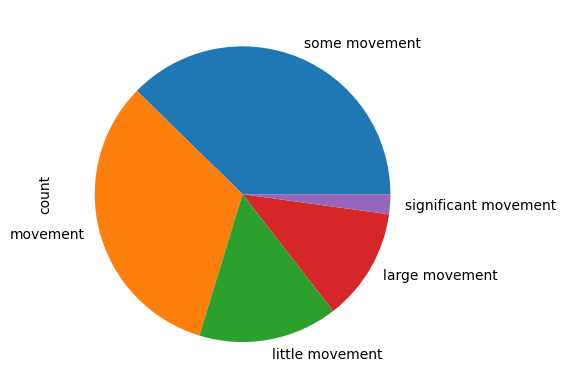

In [61]:
results_avg['movement'] = results_avg['rmsd'].map(categorize_movement)

results_avg['movement'].value_counts().plot.pie()

count      mean       std       min       25%       50%   
cdr  chain_type                                                            
CDR1 alpha        23.0  1.277489  0.674670  0.301591  0.708597  1.253725  \
     beta         23.0  0.743259  0.339884  0.243955  0.499633  0.745737   
CDR2 alpha        23.0  1.156865  0.652022  0.462977  0.761026  1.000609   
     beta         23.0  0.811468  0.735823  0.318365  0.469681  0.613337   
CDR3 alpha        23.0  2.011033  1.218452  0.241158  1.052842  1.645011   
     beta         23.0  1.235394  0.864757  0.159922  0.672891  0.943577   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       1.707544  2.741159  
     beta        0.938867  1.415011  
CDR2 alpha       1.232155  3.045568  
     beta        0.922519  3.904451  
CDR3 alpha       2.823427  4.561604  
     beta        1.574188  3.364126

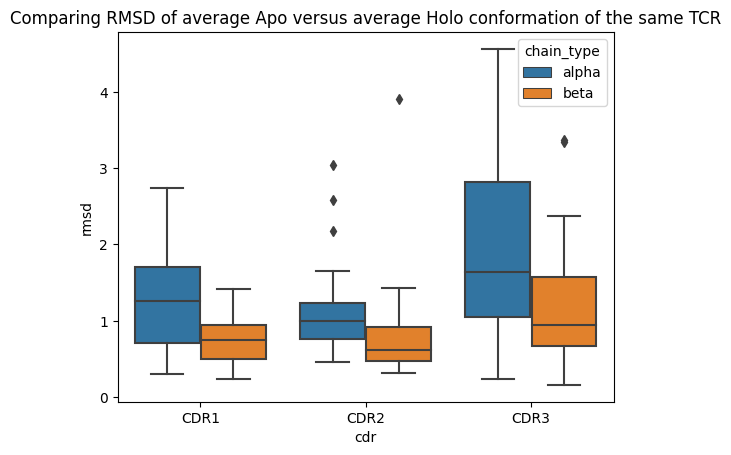

In [24]:
sns.boxplot(data=results_avg, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of average Apo versus average Holo conformation of the same TCR')

results_avg.groupby(['cdr', 'chain_type'])['rmsd'].describe()

The plots seem to show the same trend as before which is reassuring.

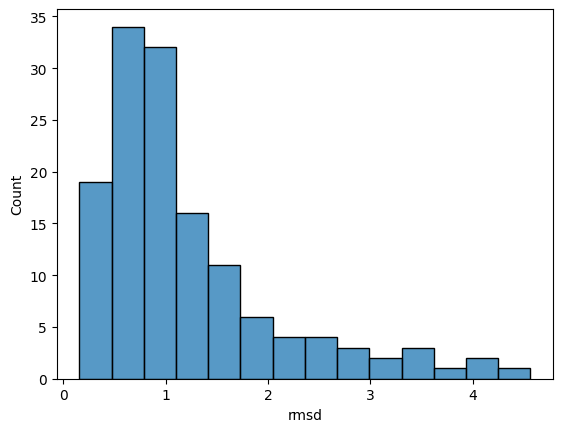

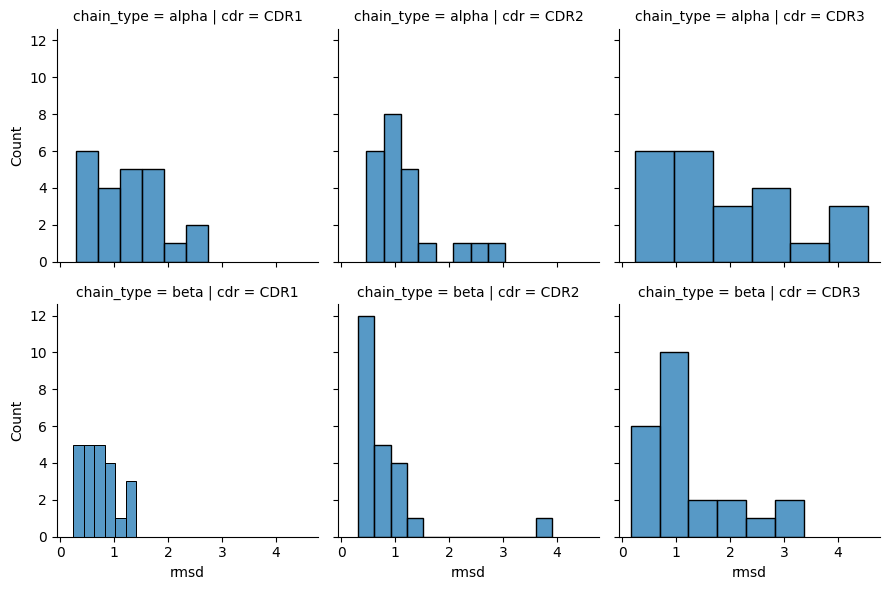

In [25]:
sns.histplot(results_avg, x='rmsd')

g = sns.FacetGrid(results_avg, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

In [26]:
factors = list(itertools.product(('alpha', 'beta'), ('CDR1', 'CDR2', 'CDR3')))
samples = []
for chain, cdr in factors:
    samples.append(results_avg.query('chain_type == @chain and cdr == @cdr')['rmsd'].to_numpy())

print(scipy.stats.kruskal(*samples))    

print('\n\nPost hoc analysis')
combos = list(itertools.combinations(factors, 2))
significance_level = 0.05 / len(combos)

p_values = []
statistics = []

for (chain_x, cdr_x), (chain_y, cdr_y) in combos:
    sample_x = results_avg.query('chain_type == @chain_x and cdr == @cdr_x')
    sample_x = sample_x.sort_values('group')
    
    sample_y = results_avg.query('chain_type == @chain_y and cdr == @cdr_y')
    sample_y = sample_y.sort_values('group')
    
    statistic, p_value = scipy.stats.wilcoxon(sample_x['rmsd'].to_numpy(), sample_y['rmsd'].to_numpy())
    
    statistics.append(statistic)
    p_values.append(p_value)

results_avg_stats = pd.DataFrame({
    'sample 1': [f"{cdr}{chain}" for (chain, cdr), _ in combos],
    'sample 2': [f"{cdr}{chain}" for _, (chain, cdr) in combos],
    'statistics': statistics,
    'p_val': p_values,
})
results_avg_stats['significant'] = results_avg_stats['p_val'].map(lambda p_val: p_val < significance_level)

results_avg_stats

KruskalResult(statistic=30.366172090682824, pvalue=1.2492090422630644e-05)


Post hoc analysis


,sample 1,sample 2,statistics,p_val,significant
0,CDR1alpha,CDR2alpha,104.0,0.314554,False
1,CDR1alpha,CDR3alpha,60.0,0.016311,False
2,CDR1alpha,CDR1beta,50.0,0.006033,False
3,CDR1alpha,CDR2beta,50.0,0.006033,False
4,CDR1alpha,CDR3beta,122.0,0.643390,False
5,CDR2alpha,CDR3alpha,49.0,0.005414,False
6,CDR2alpha,CDR1beta,57.0,0.012295,False
7,CDR2alpha,CDR2beta,49.0,0.005414,False
8,CDR2alpha,CDR3beta,137.0,0.988101,False
9,CDR3alpha,CDR1beta,6.0,0.000003,True


The statistical tests show that there is some significant differences in these results.